# IMPORTACAO

In [1]:
# Biblioteca para manuseio dos dados
import pandas as pd
import numpy as np
from numpy import random

# Biblioteca para plotar as figuras
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas suporte 
from IPython.display import display, HTML
import warnings 

# Biblioteca para manuseio de datas
import datetime as dt

# Biblioteca para remoção 
import unidecode

# Biblioteca de estatistica
import scipy.stats as stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Biblioteca de Machine Learning
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

from scipy.cluster.hierarchy import dendrogram, linkage

# FUNCOES SUPORTE

In [2]:
# Funcao somente para que o notebook preencha a tela inteira
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Funcao para mostrar todas as colunas
pd.options.display.max_columns = None

In [5]:
# Funcao que verifica a quantidade de dados ausentes 
def verificacao_ausentes(data):
    null_dict = {}

    # Calculando a porcentagem de dados nulos em cada coluna
    for col in data.columns.tolist():
        percent = np.round(data[col].isnull().sum() / data.shape[0], 2)
        null_dict[col] = percent 

    # Criando um dataframe nulo
    null_data = pd.DataFrame(null_dict.items()).rename(columns = {0: 'coluna', 1: 'percentagem_nulo'})

    # Ordenando as colunas com mais porcentagem de dados nulos
    data_return = null_data[null_data['percentagem_nulo'] > 0].sort_values(by = 'percentagem_nulo', ascending = False)
    
    return data_return

In [6]:
# Funcao que extrai substrings de uma variavel string
def extracao_substring(row, lista_substrings):
    for art in lista_substrings:
        if art in row:
            return art
        else:
            pass

In [7]:
# Funcao que realiza o bootstrap das variaveis categoricas
def categorical_bootstrap(data, var, filter, n_repetitions = 1000, n_sample = 100):
    list_mean = []
    for _ in range(n_repetitions):
        data_mean = np.mean((data[var] == filter).sample(n = n_sample)).round(4)
        list_mean.append(data_mean)
        
    mean_value = np.mean(list_mean)
    std_value = np.std(list_mean)
    qt1 = np.quantile(list_mean, 0.025)
    qt2 = np.quantile(list_mean, 0.975)
    
    sns.histplot(list_mean, bins = 30)
    plt.title(filter)
    plt.axvline((qt1), color = 'blue', label = f"2,5%: {qt1:.2f}")
    plt.axvline(mean_value, color = 'red', label = f"mean: {mean_value:.2f}")
    plt.axvline((qt2), color = 'orange', label = f"97,5%: {qt2:.2f}") 
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

In [8]:
# Funcao que remove a acentuacao dos dados
def remover_acentos(linha):
    return unidecode.unidecode(linha)

In [9]:
def classification_score(data):
    percentiles = np.percentile(data, [20, 40, 60, 80])
    score = np.digitize(data, bins=percentiles) + 1
    return score

In [10]:
def transformar_string(linha):
    return str(linha)

# CARREGAMENTO DOS DADOS 

In [11]:
crime_2022 = pd.read_excel('data/SPDadosCriminais_2022.xlsx')

In [12]:
crime_2023 = pd.read_excel('data/SPDadosCriminais_2023.xlsx')
crime_2023 = crime_2023.rename(columns = {'DATA_COMUNICACAO': 'DATA_COMUNICACAO_BO', 'DESC_PERIODO': 'DESCR_PERIODO'})

In [13]:
crime_data = pd.concat([crime_2022, crime_2023], axis = 0)

# TRANSFORMAÇÃO DOS DADOS 

## REMOVENDO ESPAÇOS EM BRANCO 
Remocao dos espacos em branco no inicio e fim da frase ou palavra na colunas do tipo string

In [15]:
# Colunas com somente strings
object_columns = crime_data.select_dtypes(object).columns.tolist()

# Remocao dos espacos em branco 
# Nao aplicando este codigo na data e hora de ocorrencia do BO
for col in object_columns:
    if col == 'DATA_OCORRENCIA_BO' or col == 'HORA_OCORRENCIA_BO':
        pass
    else:
        crime_data[col] = crime_data[col].str.strip()

## VERIFICAÇÃO DE DADOS AUSENTES

In [16]:
verificacao_ausentes(crime_data)

,coluna,percentagem_nulo
13,NUMERO_LOGRADOURO,1.00
9,DESCR_PERIODO,0.78
4,NUM_BO,0.41
8,HORA_OCORRENCIA_BO,0.31
21,DESCR_CONDUTA,0.23
14,LATITUDE,0.10
15,LONGITUDE,0.10
11,BAIRRO,0.02
7,DATA_OCORRENCIA_BO,0.01


## REMOÇÃO DE COLUNAS
Nesse caso selecionaremos algumas colunas para remover seja porque tem muitos dados ausentes ou porque nao sera util em nossa analise

In [17]:
# Lista com as colunas a serem removidas
colunas_remover = ['DATA_OCORRENCIA_BO', 'NUMERO_LOGRADOURO', 'DESCR_PERIODO', 'NUM_BO', 'LATITUDE', 'LONGITUDE', ]

# Remocao das colunas listadas
crime_data = crime_data.drop(columns = colunas_remover, axis = 1)

## PREENCHIMENTO DE DADOS AUSENTES
Como grande parte das colunas sao do tipo string nessa iremos preencher os dados ausentes de acordo com o formato de dados da coluna

In [18]:
# Removendo os dados de data de comunicacao do bo ausentes
crime_data = crime_data.dropna(subset = 'DATA_COMUNICACAO_BO')

# Preenchendo os dados categoricos com nao informado
crime_data['DESCR_CONDUTA'] = crime_data['DESCR_CONDUTA'].fillna('Nao Informado')
crime_data['BAIRRO'] = crime_data['BAIRRO'].fillna('Nao Informado')
crime_data['DESCR_TIPOLOCAL'] = crime_data['DESCR_TIPOLOCAL'].fillna('Nao Informado')
crime_data['RUBRICA'] = crime_data['RUBRICA'].fillna('Nao Informado')

# Preenchendo a dadta de ocorrencia com 00:00
crime_data['HORA_OCORRENCIA_BO'] = crime_data['HORA_OCORRENCIA_BO'].astype(str)
crime_data['HORA_OCORRENCIA_BO'] = crime_data['HORA_OCORRENCIA_BO'].str.replace('nan','00:00:00')

## ALTERAÇÃO DOS TIPOS DE DADOS 
Como a maioria dos dados estao como strings, temos que alterar os dados numericos para o seu tipo especifico assim como os dados de tempo e data

In [19]:
# Transformando em data
crime_data['DATA_COMUNICACAO_BO'] = pd.to_datetime(crime_data['DATA_COMUNICACAO_BO'],format = '%d/%m/%Y')

# Transformando em hora
crime_data['HORA_OCORRENCIA_BO'] = pd.to_datetime(crime_data['HORA_OCORRENCIA_BO'],format = '%H:%M:%S')
crime_data['HORA_OCORRENCIA_BO'] = crime_data['HORA_OCORRENCIA_BO'].dt.hour
crime_data['HORA_OCORRENCIA_BO'] = crime_data['HORA_OCORRENCIA_BO'].astype(int)

## TRATAMENTO DE DADOS
Nesse aspecto iremos tratar algumas variaveis que podem estar preenchidas incorretamente

### SUBSTITUINDO OS VALORES PREEENCHIDOS INCORRETAMENTE

In [20]:
# Remoção dos acentos nas colunas
crime_data['NATUREZA_APURADA'] = crime_data['NATUREZA_APURADA'].apply(remover_acentos)
crime_data['BAIRRO'] = crime_data['BAIRRO'].apply(remover_acentos)
crime_data['DESCR_TIPOLOCAL'] = crime_data['DESCR_TIPOLOCAL'].apply(remover_acentos)

# Inserindo a primeira letra como maiuscula
object_columns = crime_data.select_dtypes(object)
for col in object_columns:
    crime_data[col] = crime_data[col].str.capitalize()

# Substituindo os valores
pattern = '|'.join(['Delegacia eletronica 1', 'Delegacia eletronica 2', 'Delegacia eletronica 3'])
crime_data['NOME_DELEGACIA'] = crime_data['NOME_DELEGACIA'].str.replace(pattern, 'Delegacia eletronica')

## CRIAÇÃO DE VARIAVEIS
Nessa iremos criar algumas variaveis que utilizaremos na nossa analise exploratória

In [21]:
# Comando suporte para a criacao da lista artigo
#lista_artigo = crime_data['RUBRICA'].str.extract(r'(\d+[.\d]*)')

# Criacao da variavel artigo
lista_artigo = ['213', '155', '156', '303', '129', '157', '121', '33', '217', '129.', '302', '159', '333', '311', '28', '288', '163', '331',
                 '147', '330', '309', '344', '305', '18', '241', '2', '37', '15', '304', '334', '180', '12', '168', '146', '133', '34', '14', '16',
                 '19', '348', '1', '306', '140', '211', '38', '329', '250', '27', '50', '273']
crime_data['ARTIGO'] = crime_data['RUBRICA'].apply(extracao_substring, args = (lista_artigo,))

# Criação da variavel ano mes
crime_data['ANO_MES_BO'] = pd.to_datetime(crime_data['DATA_COMUNICACAO_BO']).dt.to_period('M')

# EXPLORAÇÃO DOS DADOS

In [19]:
criacao de persona mais suscetivel em cada delegacia
    - verificar se esta se desvia muito da media
natureza de cada crime com o local
    - Proporcao dos artigos em cada local
delegacias e os mais comuns tipos de crimes
horario em que e relatado mais bo
80% dos crimes que tem mais predominancia e se esta tem alguma sazonalidade
fazer um molde com os crimes em media e verificar quais delegacias que se distanciam destas

Calculo do z-score de cada delegacia por artigo
    - Clusterizacao dos dados com base no zscore de cada coluna, considerando apenas os 3 artigos

SyntaxError: invalid syntax (532251573.py, line 1)

## VERIFICAÇÃO DE SAZONALIDADE

Levando em consideração que não ocorre uma ausência ou perda de dados durante o tempo, vemos um decréscimo no número de ocorrências na metade do fim do ano, nos indicando que talvez ocorra uma sazonalidade na quantidade de BO's mas que não pode ser afirmada com tanta certeza. 

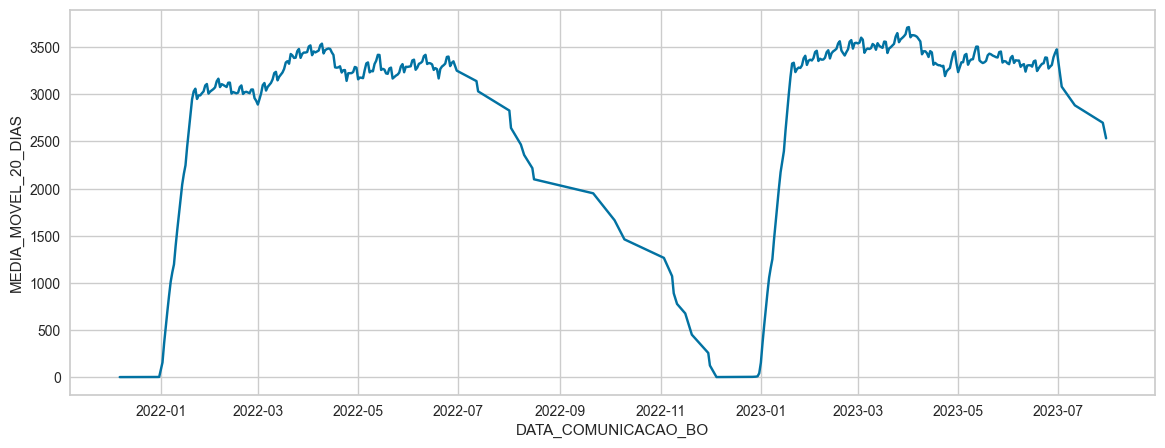

In [62]:
quant_ocorrencias = crime_data[['DATA_COMUNICACAO_BO', 'CIDADE']].groupby(['DATA_COMUNICACAO_BO']).count().reset_index().rename(columns = {'CIDADE': 'OCORRENCIAS'})
quant_ocorrencias['MEDIA_MOVEL_20_DIAS'] = quant_ocorrencias['OCORRENCIAS'].rolling(20).mean()
quant_ocorrencias = quant_ocorrencias.dropna()

plt.figure(figsize = (14,5));
sns.lineplot(data = quant_ocorrencias, x ='DATA_COMUNICACAO_BO', y = 'MEDIA_MOVEL_20_DIAS');

## HORA DE OCORRÊNCIA

Fazer o teste de hipoteses para a hora de ocorrencias

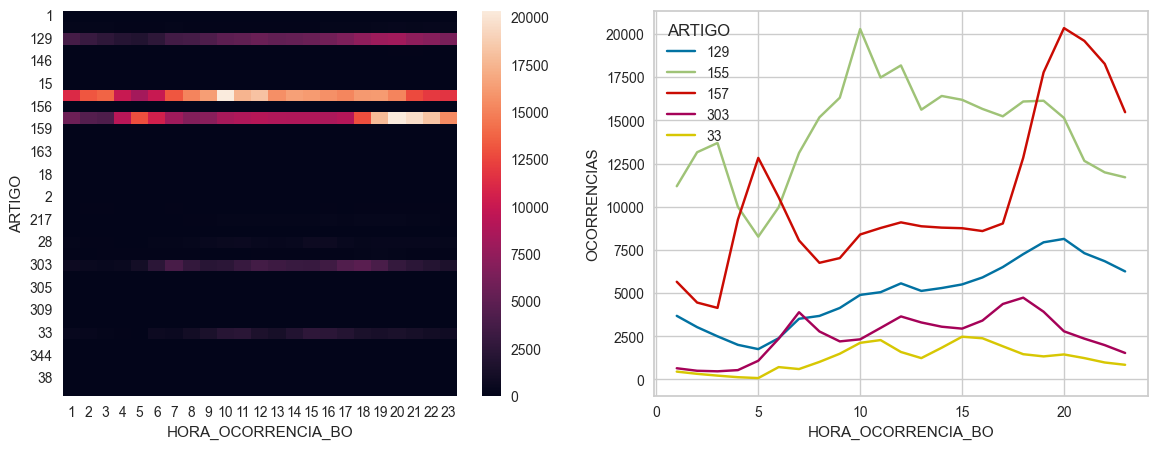

In [89]:
quant_ocorrencias = crime_data[['HORA_OCORRENCIA_BO', 'ARTIGO','CIDADE']].groupby(['HORA_OCORRENCIA_BO', 'ARTIGO']).count().reset_index().rename(columns = {'CIDADE': 'OCORRENCIAS'})
quant_ocorrencias = quant_ocorrencias[quant_ocorrencias['HORA_OCORRENCIA_BO'] != 0]
quant_ocorrencias = quant_ocorrencias.dropna(subset = 'ARTIGO')

df_pivot = quant_ocorrencias.pivot_table(index = 'ARTIGO', columns = 'HORA_OCORRENCIA_BO', values = 'OCORRENCIAS').fillna(0)

fig, axes = plt.subplots(1,2, figsize = (14,5));
sns.heatmap(df_pivot, ax = axes[0]);
sns.lineplot(quant_ocorrencias[quant_ocorrencias['ARTIGO'].isin(['129', '155', '157', '303', '33'])], 
             x = 'HORA_OCORRENCIA_BO', y=  'OCORRENCIAS', hue = 'ARTIGO', ax=axes[1]);

## COMPOSIÇÃO DA RÚBRICAS
Verificamos que grande parte dos B.O. se dão pelos crimes de **roubo (Artigo 157)**, **furto (Artigo 155)** e de **lesão corporal (Artigo 129)**, compondo estes **93% dos crimes relatados**.

Como esses crimes são os mais relatados, verificamos que a proporção media destes estão dentro da seguinte faixa: 
- **Roubo:** Com **95%** dos dados entre o **intevalo** médio de **15%** e **32%** e uma **media** de **23%**.
- **Furto:** Com **95%** dos dados entre o **intevalo** médio de **45%** e **64%** e uma **media** de **55%**.
- **Lesão Corporal:** Com **95%** dos dados entre o **intevalo** médio de **6%** e **18%** e uma **média** de **12%**.

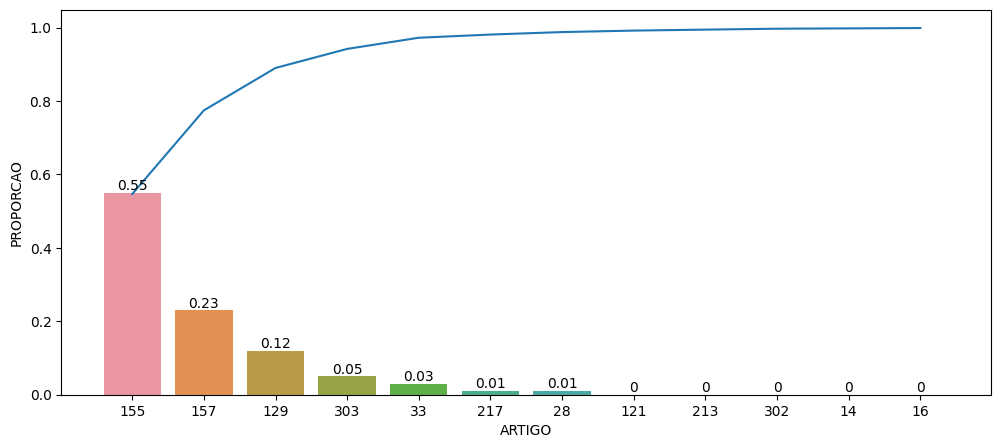

In [20]:
data_art = crime_data[['ARTIGO', 'CIDADE']].groupby('ARTIGO').count().reset_index().rename(columns = {'CIDADE': 'OCORRENCIAS'})
data_art = data_art.sort_values(by = 'OCORRENCIAS', ascending = False)
data_art['%_ACUMULADA'] = data_art['OCORRENCIAS'].cumsum() / sum(data_art['OCORRENCIAS'])

# Construção dos dados 
_ = crime_data['ARTIGO'].value_counts(normalize = True).to_frame().reset_index().rename(columns = {'proportion': 'PROPORCAO'})
_ = _.merge(data_art, on = 'ARTIGO', how = 'left')
_['PROPORCAO'] = np.round(_['PROPORCAO'],2)

# Plotagem dos dados
plt.figure(figsize = (12,5))
ax = sns.barplot(data = _.head(12), x = 'ARTIGO', y = 'PROPORCAO');
ax = sns.lineplot(data = _.head(12), x = 'ARTIGO', y = '%_ACUMULADA');
ax.bar_label(ax.containers[0], fontsize=10);

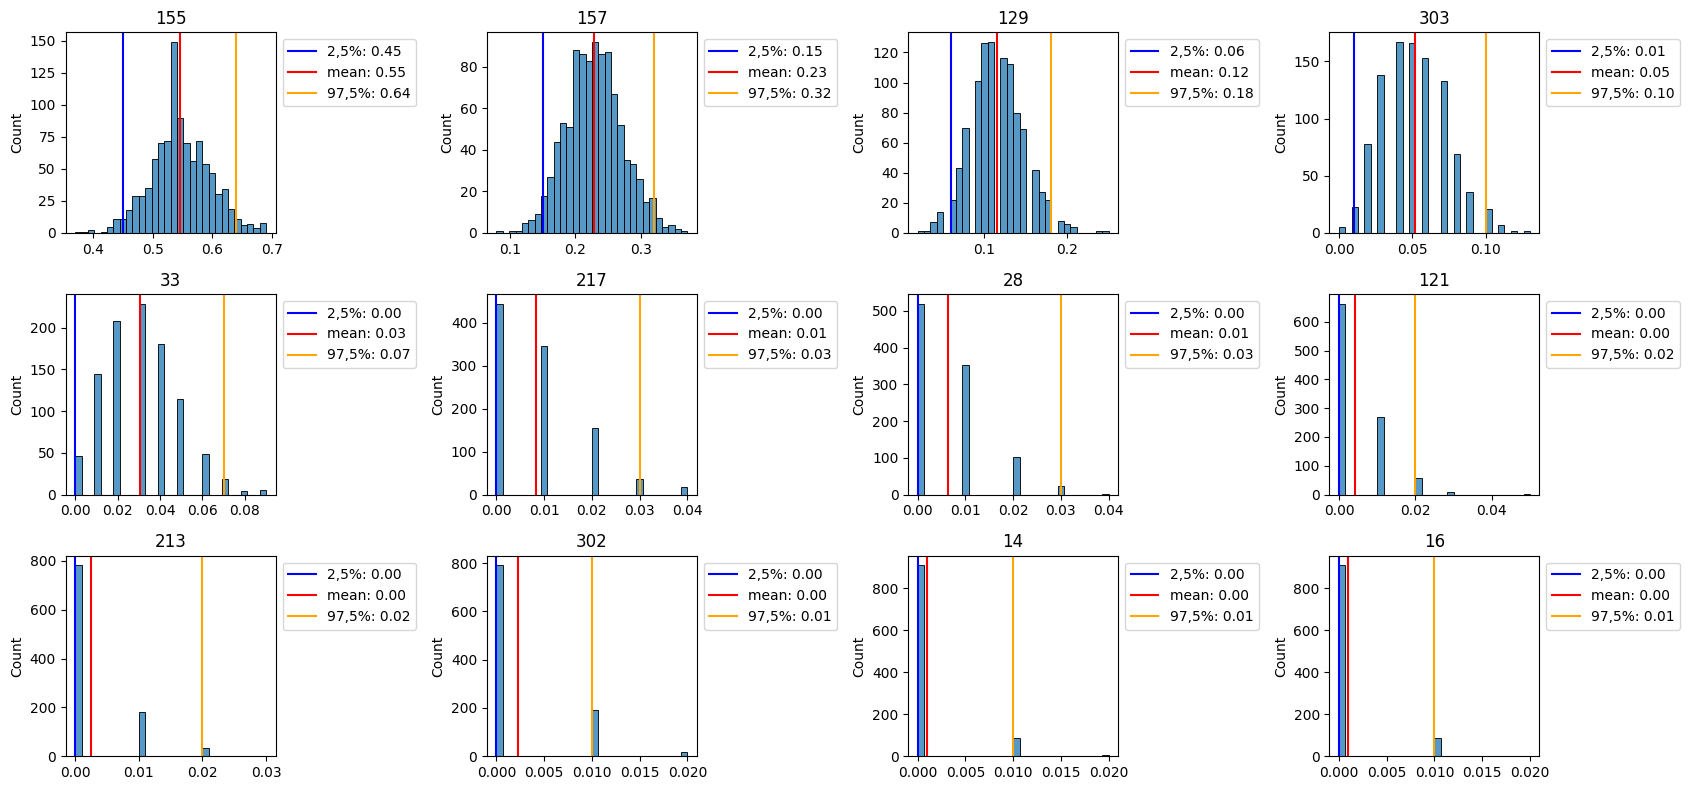

In [43]:
a = 3 # Numero de linhas
b = 4 # Numero de colunas
c = 1 # Contador

# Tamanho da figura
plt.figure(figsize = (17,8))

# Lista com os artigos
list_filters = ['155', '157', '129', '303', '33', '217', '28', '121', '213', '302', '14', '16']

# Loop realizando o bootstraping de cada variavel e plotando em um grafico
for filter in list_filters:
    plt.subplot(a, b, c)
    categorical_bootstrap(crime_data, var = 'ARTIGO', filter = filter)
    c = c + 1

plt.tight_layout()
plt.show()

## VERIFICAÇÃO POR LOCAIS DE OCORRÊNCIA
Como temos 3 artigos com mais ocorrência (155, 157, 129 e 303) iremos verificar quais locais mais comuns na ocorrência desses.

### ARTIGO 155

- Ao realizarmos a probabilidade condicional verificamos que grande parte dos furtos ocorrem em vias publicas, sendo que se tem uma chance de 55% de ser furtado um objeto em uma via publica e 85% de chance de um veiculo ser furtado.

- Outro aspecto também que em lugares privados as residências são outro alvo de furtos

In [91]:
# Filtrando os dados pelo artigo
_ = crime_data[crime_data['ARTIGO'] == '155']

# Construindo a tabela 
data_155_cond_prob = pd.crosstab(_['DESCR_TIPOLOCAL'], _['NATUREZA_APURADA'])[['Furto - outros', 'Furto de veiculo']].reset_index()

# Construindo a probabilidade condicional
data_155_cond_prob['prob_outros'] = [row/sum(data_155_cond_prob['Furto - outros']) for row in data_155_cond_prob['Furto - outros']]
data_155_cond_prob['prob_veiculo'] = [row/sum(data_155_cond_prob['Furto de veiculo']) for row in data_155_cond_prob['Furto de veiculo']]

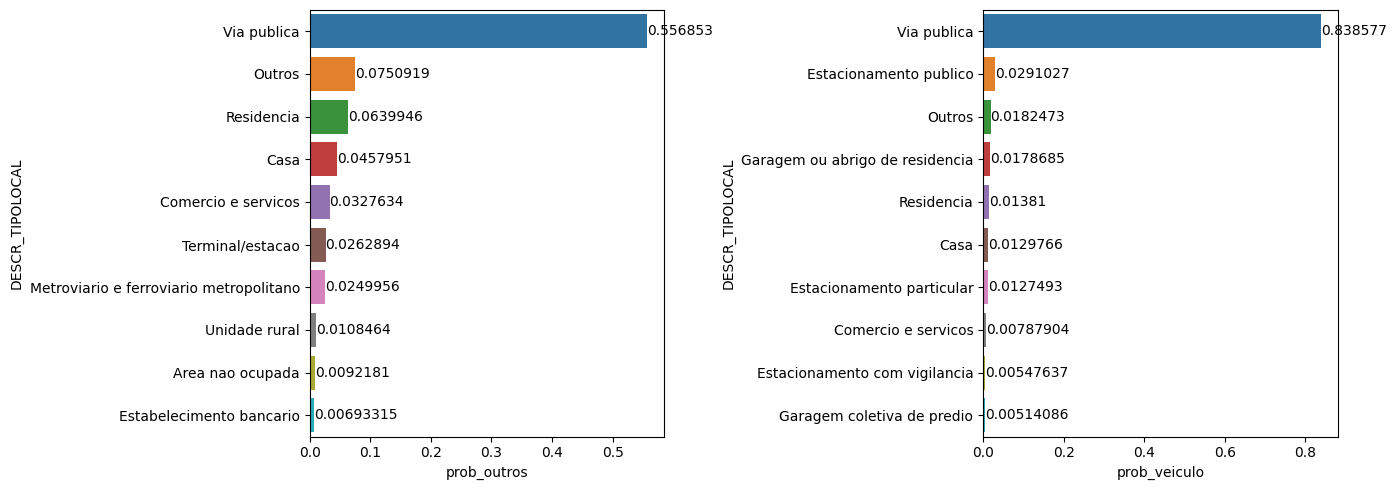

In [146]:
fig, axes = plt.subplots(1,2, figsize = (14,5))

sns.barplot(data = data_155_cond_prob.sort_values(by = 'prob_outros', ascending = False).head(10), 
            x = 'prob_outros', y = 'DESCR_TIPOLOCAL', ax = axes[0])
axes[0].bar_label(axes[0].containers[0])

sns.barplot(data = data_155_cond_prob.sort_values(by = 'prob_veiculo', ascending = False).head(10), 
            x = 'prob_veiculo', y = 'DESCR_TIPOLOCAL', ax = axes[1])
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()

### ARTIGO 157

No crime de roubo vemos que tem um comportamento similar ao de furto, grande parte se da em vias publicas, mas apesar disso alguns crimes tem algumas pecularidades

- Em outros tipos de roubos verificamos que o segundo local com mais roubos sao setores de comercio e assim como roubos em terminais, com uma probabilidade de aproximadamente 1%.

- Em roubos de veiculos verificamos que aproximadamente 3% ocorrem com veículos em movimento, ocorrendo provavelmente em vias públicas.

- Em roubos de carga, vemos que em aproximadamente 3% ocorrem em rodovias e 1% em acostamentos, mas nessa necessitamos de mais dados. 

In [148]:
# Filtrando os dados pelo artigo
_ = crime_data[crime_data['ARTIGO'] == '157']

# Construindo a tabela 
data_157_cond_prob = pd.crosstab(_['DESCR_TIPOLOCAL'], _['NATUREZA_APURADA']).reset_index()

# Construindo a probabilidade condicional
data_157_cond_prob['prob_outros'] = [row/sum(data_157_cond_prob['Roubo - outros']) for row in data_157_cond_prob['Roubo - outros']]
data_157_cond_prob['prob_veiculo'] = [row/sum(data_157_cond_prob['Roubo de veiculo']) for row in data_157_cond_prob['Roubo de veiculo']]
data_157_cond_prob['prob_carga'] = [row/sum(data_157_cond_prob['Roubo de carga']) for row in data_157_cond_prob['Roubo de carga']]

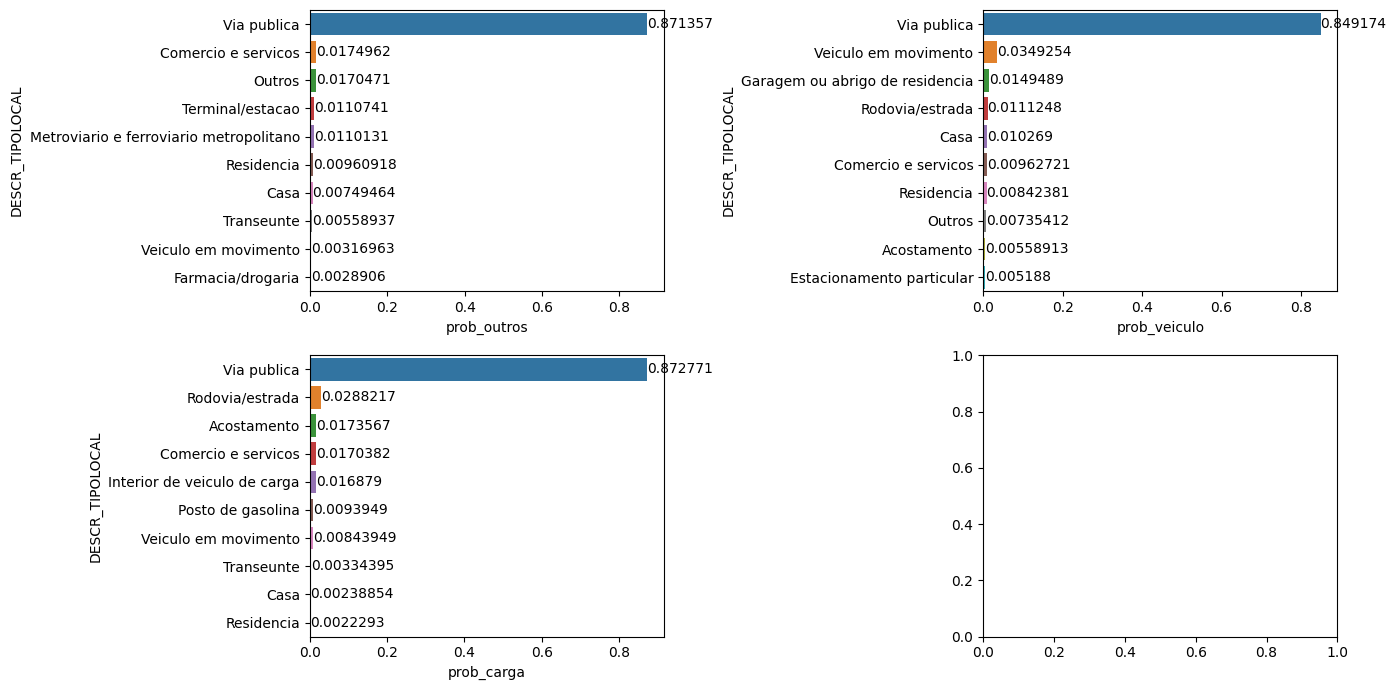

In [152]:
fig, axes = plt.subplots(2,2, figsize = (14,7))

sns.barplot(data = data_157_cond_prob.sort_values(by = 'prob_outros', ascending = False).head(10), 
            x = 'prob_outros', y = 'DESCR_TIPOLOCAL', ax = axes[0,0])
axes[0,0].bar_label(axes[0,0].containers[0])

sns.barplot(data = data_157_cond_prob.sort_values(by = 'prob_veiculo', ascending = False).head(10), 
            x = 'prob_veiculo', y = 'DESCR_TIPOLOCAL', ax = axes[0,1])
axes[0,1].bar_label(axes[0,1].containers[0])

sns.barplot(data = data_157_cond_prob.sort_values(by = 'prob_carga', ascending = False).head(10), 
            x = 'prob_carga', y = 'DESCR_TIPOLOCAL', ax = axes[1,0])
axes[1,0].bar_label(axes[1,0].containers[0])

plt.tight_layout()
plt.show()

### ARTIGO 129

Nesse, apesar de grande parte dos crimes ainda ocorrerem em vias publicas, vemos algumas particularidades:

- Em crimes de lesão dolosa, tem em torno de 45% de ocorrer em residencias privadas, como não temos informações das vítimas, não temos como precisar qual gênero ou idade que mais frequentes dentro desses locais, mas e algo que apresenta um comportamento bem distinto dos artigos anteriores.

- Em lesão culposa vemos que grande parte ocorre em vias publicas, provavelmente pode ter alguma correlação com o roubo, ou seja, a pessoa é roubada e também sofre uma lesão, mas não temos dados para inferir isso. Outro aspecto é que tem uma probabilidade de aproximadamente 10% das ocorrências ocorrerem dentro de residências privadas.

In [156]:
_ = crime_data[crime_data['ARTIGO'] == '129']

# Construindo a tabela 
data_129_cond_prob = pd.crosstab(_['DESCR_TIPOLOCAL'], _['NATUREZA_APURADA']).reset_index()

# Construindo a probabilidade condicional
data_129_cond_prob['prob_dolosa'] = [row/sum(data_129_cond_prob['Lesao corporal dolosa']) for row in data_129_cond_prob['Lesao corporal dolosa']]
data_129_cond_prob['prob_culposa'] = [row/sum(data_129_cond_prob['Lesao corporal culposa - outras']) for row in data_129_cond_prob['Lesao corporal culposa - outras']]

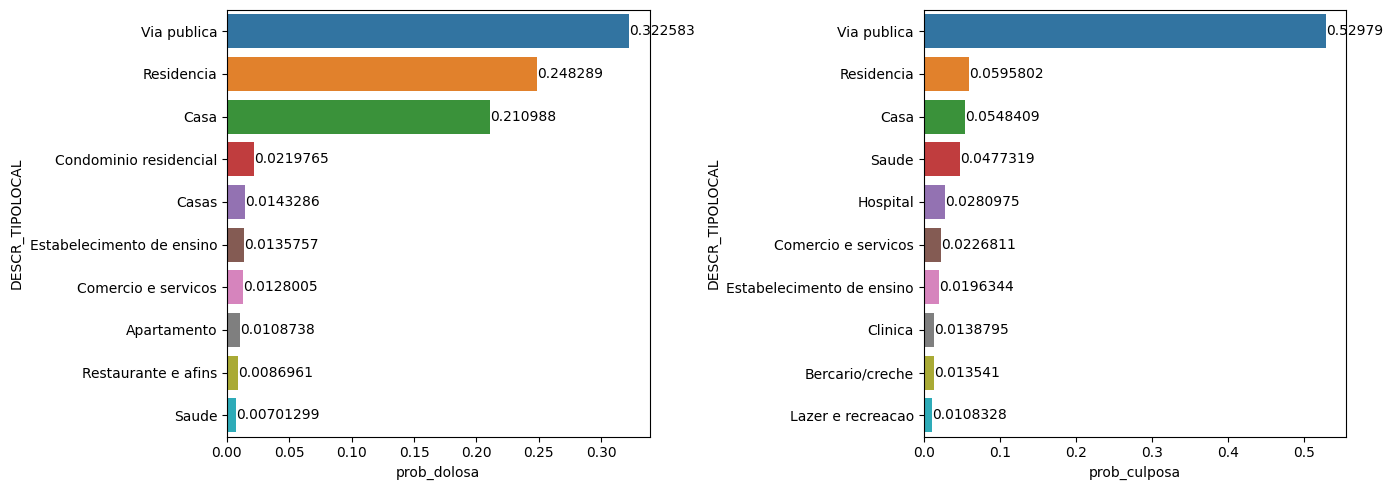

In [158]:
fig, axes = plt.subplots(1,2, figsize = (14,5))

sns.barplot(data = data_129_cond_prob.sort_values(by = 'prob_dolosa', ascending = False).head(10), 
            x = 'prob_dolosa', y = 'DESCR_TIPOLOCAL', ax = axes[0])
axes[0].bar_label(axes[0].containers[0])

sns.barplot(data = data_129_cond_prob.sort_values(by = 'prob_culposa', ascending = False).head(10), 
            x = 'prob_culposa', y = 'DESCR_TIPOLOCAL', ax = axes[1])
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()

## AGRUPAMENTO DE DELEGACIAS POR CRIMES
- Composição das delegacias pela porcentagens de cada crime, ou seja, se a delegacia entrar entre uma porcentagem de 1 a 10% de 157, 1 a 55 do 155 e por ai vai, compondo as 
Para classificarmos os dados de delegacias em agrupamentos, realizaremos os seguintes passos: 
- Realizare

In [20]:
deleg_prop = crime_data.groupby('NOME_DELEGACIA')['ARTIGO'].value_counts(normalize = True).to_frame().reset_index()
deleg_prop_art = deleg_prop.pivot_table(index = 'NOME_DELEGACIA', columns = 'ARTIGO', values = 'proportion')[['155', '157', '129', '303']].round(3)
deleg_prop_art = deleg_prop_art.fillna(0)

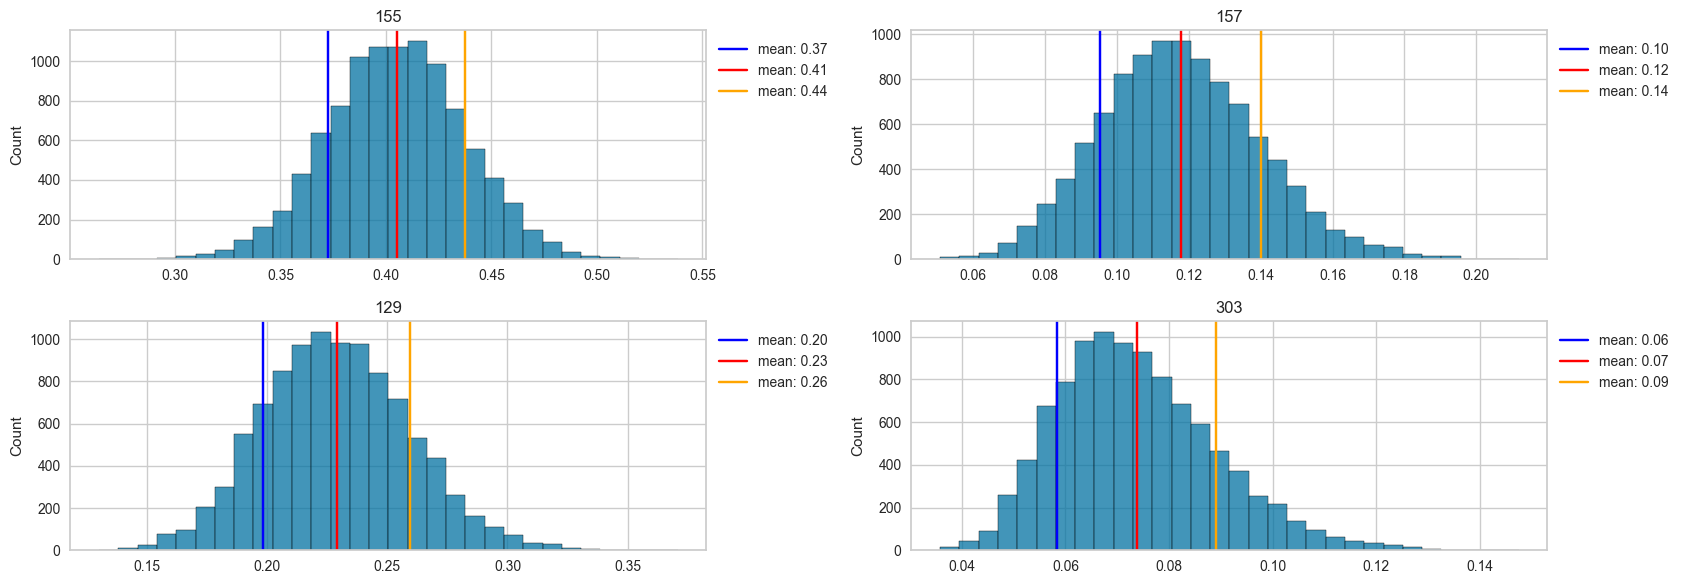

In [20]:
a = 2 # Numero de linhas
b = 2 # Numero de colunas
c = 1 # Contador

plt.figure(figsize = (17,6)) 

for col in ['155', '157', '129', '303']:
    plt.subplot(a, b, c)
    list_mean = []
    for _ in range(10000):
        mean_value = deleg_prop_art[col].sample(n = 50).values.mean()
        list_mean.append(mean_value)
        
    mean_value = np.mean(list_mean)
    std_value = np.std(list_mean)

    sns.histplot(list_mean, bins = 30)
    plt.title(col)

    plt.axvline(mean_value - std_value, color = 'blue', label = f"mean: {(mean_value - std_value):.2f}")
    plt.axvline(mean_value, color = 'red', label = f"mean: {mean_value:.2f}")
    plt.axvline(mean_value + std_value, color = 'orange', label = f"mean: {(mean_value + std_value):.2f}")
  
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
    c += 1

plt.tight_layout()
plt.show()

In [33]:
deleg_prop_art['155_class'] = classification_score(deleg_prop_art['155'])
deleg_prop_art['157_class'] = classification_score(deleg_prop_art['157'])
deleg_prop_art['129_class'] = classification_score(deleg_prop_art['129'])
deleg_prop_art['303_class'] = classification_score(deleg_prop_art['303'])
deleg_prop_art['total_class'] = deleg_prop_art[['155_class', '157_class', '129_class', '303_class']].sum(axis = 1)
deleg_prop_art['class_geral'] = pd.qcut(deleg_prop_art['total_class'], q=4, labels=[1, 2, 3, 4])

In [ ]:
def rfv_score(data):
    percentiles = np.percentile(data, [20, 40, 60, 80])
    score = np.digitize(data, bins=percentiles) + 1
    return score

In [117]:
crime_80 = crime_data[crime_data['ARTIGO'].isin(['155', '157', '129', '303'])]
cluster_data = crime_80[['NOME_DELEGACIA', 'ARTIGO' ,'CIDADE']].groupby(['NOME_DELEGACIA', 'ARTIGO']).count().reset_index()\
                        .pivot_table(index = 'NOME_DELEGACIA', columns = 'ARTIGO', values = 'CIDADE').fillna(0)

for col in cluster_data.columns:
    cluster_data[col] = np.log1p(cluster_data[col])

In [123]:
cluster_data

ARTIGO,129,155,157,303
NOME_DELEGACIA,,,,
01ª ddm campinas,5.533389,1.791759,0.000000,0.000000
01ª ddm centro,7.178545,3.295837,2.833213,0.693147
01º d.p. adamantina,2.944439,3.988984,0.693147,4.682131
01º d.p. americana,4.795791,5.918894,4.127134,5.288267
01º d.p. andradina,3.465736,5.298317,2.484907,4.077537
...,...,...,...,...
Sig del.sec.diadema,0.000000,1.945910,1.609438,1.098612
Sig del.sec.franco da rocha,0.693147,2.079442,2.772589,0.000000
Sig del.sec.santo andre,0.000000,1.945910,1.098612,0.693147


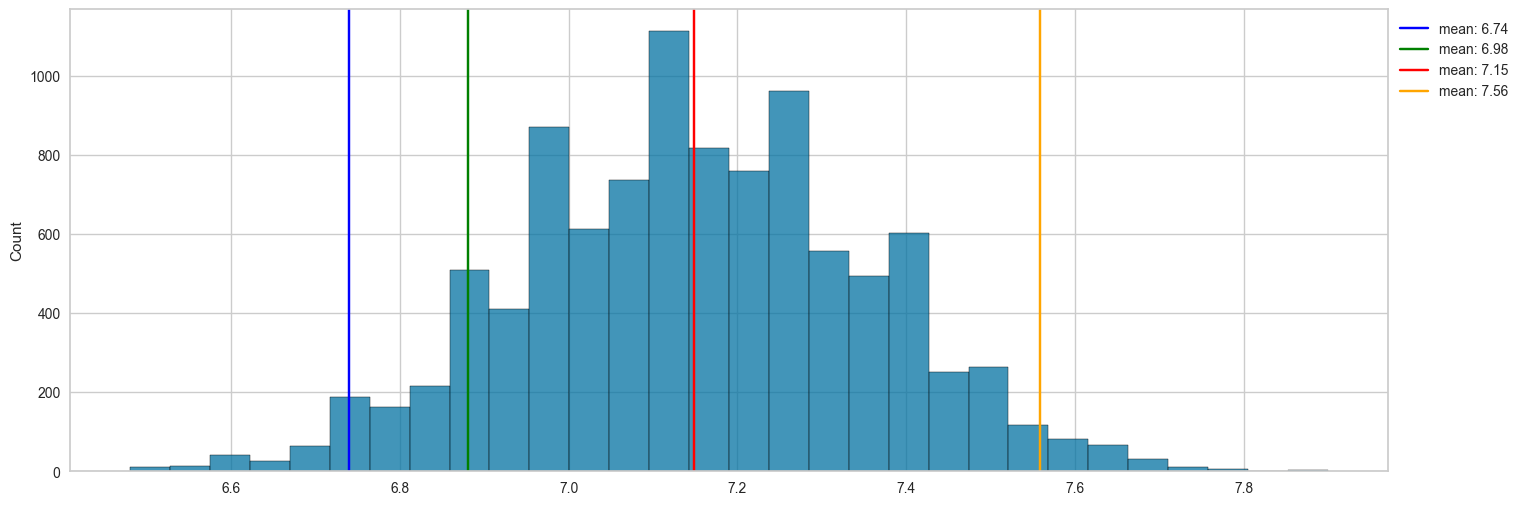

In [61]:
list_mean_total = []
for _ in range(10000):
    mean_total = deleg_prop_art['total_class'].sample(n = 50).values.mean()
    list_mean_total.append(mean_total)

mean_total = np.mean(list_mean_total)
std_total = np.std(list_mean_total)

plt.figure(figsize = (17,6))
sns.histplot(list_mean_total, bins = 30)

plt.axvline(mean_total - 2 * std_total, color = 'blue', label = f"mean: {(mean_total - 2 * std_total):.2f}")
plt.axvline(np.percentile(list_mean_total, 10), color = 'green', label = f"mean: {np.percentile(list_mean_total, 20):.2f}")
plt.axvline(mean_total, color = 'red', label = f"mean: {mean_total:.2f}")
plt.axvline(mean_total + 2 * std_total, color = 'orange', label = f"mean: {(mean_total + 2 * std_total):.2f}")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')